<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [5]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 2.7 kB/s 


In [7]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311914 sha256=83111127fadc565ec75e617cf671f071a923562994120edd87e6ca895f3ab37e
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [1]:
import hdbscan

In [101]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

Full chords:

In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-08 09:36:15--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 142.250.128.138, 142.250.128.100, 142.250.128.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iqg5cqs4q1p4432373c02i0g5din2a99/1636364175000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-08 09:36:16--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iqg5cqs4q1p4432373c02i0g5din2a99/1636364175000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-

Simplified chords:

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_' -O input_seq.txt

--2021-11-08 09:36:18--  https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_
Resolving docs.google.com (docs.google.com)... 142.250.152.139, 142.250.152.102, 142.250.152.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kr76f2f4r9s0795ih1iihqpbkv77e5rp/1636364175000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download [following]
--2021-11-08 09:36:18--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kr76f2f4r9s0795ih1iihqpbkv77e5rp/1636364175000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10-

Meta Data:

In [7]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-08 09:36:20--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 108.177.111.101, 108.177.111.138, 108.177.111.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9ashsobjlelbg3snsrodk1lshc9apv1u/1636364175000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-08 09:36:21--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9ashsobjlelbg3snsrodk1lshc9apv1u/1636364175000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 209.85.147.132, 2607:f8b0:4001:c20::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-

In [8]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [9]:
data = [line.split(' ') for line in lines]

### Meta Data

In [10]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.columns

Index(['id', 'file_name', 'title', 'composer', 'year', 'year_truncated',
       'tonality', 'tune_key', 'tune_mode', 'structure', 'num_bars',
       'time_signature', 'cycle_fifths_order', 'style', 'musicbrainz_id',
       'wikidata_id', 'wikidata_allmusic', 'wiki_link', 'wikidata_description',
       'lyricist'],
      dtype='object')

In [11]:
titles = meta.loc[:, ['id', 'title', 'tune_mode']].drop_duplicates()
titles.set_index('id', inplace=True)

In [12]:
assert len(data) == len(titles)

# Chord N-Grams



In [13]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [14]:
def list_to_ngrams(data, n=2, sep='-'):
  out = []
  for row in data:
    out.append(ngrams(row, n, sep))

  return out

In [15]:
data_ngrams = list_to_ngrams(data, 3)

In [16]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

In [17]:
df_chords = raw_chords_to_df(data_ngrams)
df_chords.head(10)

,chord,count
14,Dm7-G7-CM7,1628
76,G7-C-C,1471
136,A7-Dm7-G7,1427
900,C-C-C,1056
184,Dm7-G7-C6,996
86,G7-G7-C,967
135,Em7-A7-Dm7,828
862,D7-G7-C,760
182,A7-D7-G7,742
71,Am7-Dm7-G7,650


In [18]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-11-08 09:36:34,339 : INFO : NumExpr defaulting to 2 threads.


# Word Embeddings

In [19]:
from gensim.models import word2vec


In [20]:
train_data = data_ngrams
EMBED_SIZE = 100

In [21]:
# train model
model = gensim.models.Word2Vec(train_data, 
                               vector_size=EMBED_SIZE,
                               min_count=5,
                               sample=1, #0.1,
                               sg=1,
                               window=2,
                               negative=2,
                               epochs=50,
                               workers=4,
                               #alpha=0.025,
                               )

2021-11-08 09:36:38,291 : INFO : collecting all words and their counts
2021-11-08 09:36:38,296 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-08 09:36:38,320 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-08 09:36:38,321 : INFO : Creating a fresh vocabulary
2021-11-08 09:36:38,342 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2440 unique words (18.152060705252193%% of original 13442, drops 11002)', 'datetime': '2021-11-08T09:36:38.342767', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-08 09:36:38,344 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 71559 word corpus (79.92025732091402%% of original 89538, drops 17979)', 'datetime': '2021-11-08T09:36:38.344359', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021,

In [22]:
# summarize vocabulary
vocab = model.wv.index_to_key
print(vocab[:10])

['Dm7-G7-CM7', 'G7-C-C', 'A7-Dm7-G7', 'C-C-C', 'Dm7-G7-C6', 'G7-G7-C', 'Em7-A7-Dm7', 'D7-G7-C', 'A7-D7-G7', 'Am7-Dm7-G7']


In [23]:
weights = model.syn1neg

In [24]:
print(weights.shape)
vec_df = pd.DataFrame(weights, index=vocab)
vec_df.head()

(2440, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Dm7-G7-CM7,0.665212,-0.721651,-0.093282,0.096493,-0.157847,0.418966,-0.113997,-0.689197,0.542471,0.187444,0.284059,0.857902,-0.016129,0.136655,-0.356115,0.565895,-0.013131,0.820492,0.101852,0.439617,-0.650100,-0.162299,-0.053564,0.086868,0.144139,-0.058987,0.472513,0.309170,0.319090,-0.111030,-0.619489,-0.102745,0.326506,0.014334,-0.437683,-0.071877,-0.270926,0.378059,0.200074,0.521034,...,-0.387731,-0.102302,0.434002,-0.409419,0.402042,-0.467006,0.209442,-0.443586,0.209445,-0.709556,0.408350,-0.696812,-0.788955,0.729176,-0.331134,-0.531729,-0.293322,0.467005,0.105210,-0.055025,0.250053,-0.114886,0.186445,-0.655576,-0.213303,-0.062389,0.260528,-0.263868,-0.510957,-0.555003,-0.550898,-0.035467,-0.326370,0.012869,-0.722473,-0.216985,-0.362598,0.612217,-0.254452,-0.291411
G7-C-C,0.402717,-0.376155,-0.267085,0.097312,-0.053858,0.506028,0.399835,-1.320062,-0.099346,0.029187,0.349608,0.165372,0.272298,-0.303498,-0.632115,0.016184,0.315749,0.565317,-0.443721,0.434780,-0.591060,-0.205116,-0.376001,-0.157325,-0.944654,0.003993,-0.449401,0.077821,1.003292,0.178014,-0.604641,-0.247325,0.598571,-0.035150,-0.576155,-0.263083,0.313076,0.823109,-0.323186,1.566905,...,-0.085001,-0.931056,0.612833,-0.130981,-0.022224,-0.839689,0.217047,0.518405,0.120747,-0.800725,0.023941,-0.892302,-0.178545,0.721812,-0.894713,-0.557808,-0.064574,0.192504,0.069657,-0.153032,-0.087456,0.537321,-0.254176,-0.242330,0.151481,0.086942,0.301698,-0.299443,-0.221601,-0.305066,0.090438,-0.234054,-0.743399,0.248021,-0.930041,-0.532629,-0.361593,0.637012,0.206778,-0.608613
A7-Dm7-G7,0.492828,-0.534673,-0.255432,0.136965,-0.052380,0.354453,-0.076869,-0.630149,0.341116,0.239172,0.179837,0.748763,-0.037164,0.160682,-0.267398,0.413993,-0.091046,0.806633,0.131874,0.160294,-0.404121,-0.105964,-0.108988,0.032250,-0.109875,-0.038018,0.530738,0.190562,0.249626,-0.106949,-0.404843,-0.038151,0.449754,0.197347,-0.373919,-0.034860,-0.069472,0.636908,0.133324,0.410173,...,-0.298417,-0.116690,0.509363,-0.379001,0.241207,-0.304729,0.428816,-0.216619,0.206267,-0.552553,0.366722,-0.761722,-0.798712,0.647484,-0.225256,-0.308951,-0.266036,0.478202,0.252318,0.063646,0.049471,-0.318340,0.159177,-0.523484,-0.046929,-0.092556,0.210673,-0.089278,-0.323517,-0.475168,-0.458001,-0.006273,-0.353130,-0.042504,-0.542606,-0.332072,-0.283436,0.521932,-0.099885,-0.203633
C-C-C,0.432599,-0.373296,-0.255253,0.103029,-0.024178,0.580328,0.424959,-1.431887,-0.073433,-0.081647,0.424352,0.113901,0.293905,-0.231387,-0.597688,0.018497,0.388191,0.550203,-0.537654,0.553746,-0.768073,-0.320851,-0.474158,-0.182289,-0.999490,0.033406,-0.476409,0.308329,1.129510,0.243160,-0.610043,-0.337664,0.711694,-0.000949,-0.721042,-0.279682,0.332663,0.855857,-0.435505,1.820373,...,-0.125872,-1.040505,0.759996,-0.105969,-0.054371,-0.922207,0.270616,0.558112,0.069867,-0.852825,0.115612,-0.977982,-0.131544,0.810073,-1.006103,-0.633455,-0.128627,0.212283,-0.018381,-0.230391,-0.161279,0.671250,-0.276843,-0.241100,0.098386,0.175832,0.331352,-0.431519,-0.201282,-0.409872,0.100549,-0.278753,-0.835871,0.210285,-1.041515,-0.702736,-0.427173,0.723964,0.186398,-0.671366
Dm7-G7-C6,0.591202,-0.591211,-0.088471,0.346971,-0.006207,0.413515,-0.250236,-0.576382,0.403081,0.120466,0.106300,0.763925,0.075849,0.317623,-0.217213,0.613648,-0.215435,0.837231,0.131460,0.330709,-0.319410,-0.127704,-0.174179,0.075449,0.014407,-0.136878,0.617260,0.228093,0.290297,0.000179,-0.533641,0.037429,0.578792,0.299730,-0.356979,0.042938,-0.127349,0.538937,0.135547,0.591133,...,-0.288190,0.030058,0.562116,-0.569973,0.267990,-0.327766,0.453198,-0.299945,0.016317,-0.498587,0.425911,-0.849736,-0.894581,0.770265,-0.082495,-0.320782,-0.332349,0.402159,0.268914,0.115449,-0.037021,-0.280068,0.253734,-0.542197,-0.171356,-0.124188,0.218690,-0.10432

### Visualize the embedding weight for each chord ngram


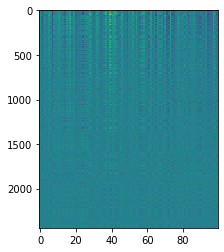

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(weights, interpolation='nearest')
ax.set_aspect(0.05)

In [28]:
vocab_set = set(vocab)
model_dict = dict(zip(vocab, weights))

## Calculate Embeddings for Tunes

For all ngrams in a tune, average the corresponding ngram embedding vectors to determine the tune embedding vector.

In [29]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = vocab_set

  features = []
  for tune in corpus:
    features.append(average_word_vectors(tune, 
                                         model, 
                                         vocabulary, 
                                         num_features)
    )

  return np.array(features)

In [30]:
# get document level embeddings
corpus = data_ngrams
num_features = EMBED_SIZE

ft_doc_features = averaged_word_vectorizer(corpus=corpus, 
                                           model=model_dict,
                                           num_features=num_features)

df_features = pd.DataFrame(ft_doc_features)

In [31]:
df_features.shape

(2046, 100)

In [32]:
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.157890,-0.211163,0.004488,0.065561,-0.032995,0.094534,-0.064651,-0.117917,0.197359,0.059439,0.065224,0.291354,0.009912,0.094616,-0.043270,0.218089,-0.058169,0.266275,0.073044,0.158431,-0.120798,-0.057971,0.013865,0.028925,0.108731,-0.050925,0.245283,0.118860,0.027947,-0.071439,-0.140655,0.028754,0.095430,0.052247,-0.129568,-0.063717,-0.123669,0.059048,0.107806,0.059964,...,-0.120925,0.121646,0.144800,-0.113173,0.177128,-0.104293,0.114957,-0.196409,0.005593,-0.151718,0.125235,-0.183349,-0.286025,0.217938,-0.008982,-0.129778,-0.098297,0.209587,0.081053,0.036472,0.135797,-0.092366,0.127414,-0.232094,-0.097164,-0.048423,0.068670,-0.021273,-0.196293,-0.219697,-0.177291,0.015046,-0.073577,0.031451,-0.152606,-0.067267,-0.104826,0.183753,-0.119506,-0.018762
1,0.402097,-0.318557,-0.053668,0.069929,-0.155629,0.303671,-0.054297,-0.354023,0.240004,0.071467,0.110117,0.516346,0.031152,0.040356,-0.201500,0.289609,-0.064162,0.441977,0.010899,0.226516,-0.310514,-0.071316,-0.038510,0.107804,0.138776,-0.007888,0.279143,0.103031,0.119948,-0.033857,-0.411499,-0.063406,0.114110,0.070875,-0.193992,-0.013529,-0.154895,0.191106,0.058698,0.246482,...,-0.256265,0.017909,0.162988,-0.286755,0.228561,-0.252002,0.154942,-0.262865,0.005265,-0.260636,0.221366,-0.333327,-0.469209,0.375869,-0.125022,-0.297455,-0.075078,0.197616,0.080033,-0.009821,0.078627,-0.105935,0.131215,-0.451845,-0.075307,-0.059214,0.110080,-0.113247,-0.270734,-0.277692,-0.281563,-0.009512,-0.096590,-0.049578,-0.321765,-0.112145,-0.224999,0.315865,-0.156922,-0.100821
2,0.276927,-0.155301,-0.035382,-0.023151,-0.117388,0.231487,-0.062343,-0.242279,0.217750,0.074844,0.101034,0.409333,0.003984,-0.013371,-0.099585,0.169778,-0.076975,0.283231,-0.007064,0.152890,-0.196641,-0.048248,-0.037462,0.115663,0.161833,0.011646,0.204681,0.036142,0.078308,0.002523,-0.291052,-0.034415,-0.039152,-0.021852,-0.078475,-0.056705,-0.231324,0.048403,0.033365,0.116820,...,-0.164412,0.067058,0.095630,-0.139120,0.211266,-0.237603,0.113036,-0.233438,-0.056264,-0.087039,0.215692,-0.148262,-0.313850,0.262380,-0.091652,-0.180662,-0.041743,0.110210,0.045766,-0.029306,0.125820,-0.103901,0.119363,-0.321793,-0.106456,-0.085780,0.056637,-0.122398,-0.185998,-0.149216,-0.195645,0.007574,-0.017645,-0.018796,-0.223401,-0.055141,-0.142957,0.182280,-0.116503,-0.044642
3,0.247960,-0.277316,-0.115585,0.100180,-0.081096,0.248565,0.167771,-0.696768,-0.033451,0.123586,0.167424,0.231204,0.126625,-0.098587,-0.307720,0.142815,0.092879,0.369699,-0.130198,0.153184,-0.179488,-0.000194,-0.164617,-0.077145,-0.413017,0.001238,-0.065820,0.084480,0.398330,0.054379,-0.311395,-0.091744,0.326312,0.023805,-0.283915,-0.081882,0.107173,0.424370,-0.158899,0.720288,...,-0.060225,-0.358312,0.337673,-0.085906,0.024102,-0.432324,0.130031,0.113843,0.148772,-0.381908,0.077495,-0.527500,-0.233753,0.389415,-0.349072,-0.262609,-0.059561,0.174950,0.075866,0.037095,0.026675,0.112344,-0.088258,-0.185089,0.059401,-0.013040,0.170235,-0.034492,-0.184460,-0.229443,-0.123572,-0.061273,-0.322539,0.083286,-0.446852,-0.270995,-0.201986,0.366250,0.032779,-0.261540
4,0.099840,-0.099527,-0.089056,0.029672,-0.001520,0.093020,-0.003592,-0.249681,0.016274,-0.015942,0.169606,0.119988,0.017296,0.040284,-0.011941,0.108992,0.012190,0.104212,-0.044889,0.044375,-0.176930,-0.003173,-0.107383,0.010721,-0.051785,0.031242,0.108885,0.160213,0.118305,0.014223,-0.038683,-0.060469,0.128595,-0.007952,-0.126879,-0.040853,-0.020632,0.078546,-0.058157,0.198396,...,-0.060359,-0.027780,0.145318,-0.031488,0.004092,-0.110903,0.146893,0.023987,0.042416,-0.085477,0.101803,-0.178298,-0.122392,0.098407,-0.090664,-0.052127,-0.015040,0.079596,0.016005,-0.025789,0.097372,-0.054893,-0.002084,-0.065972,0.050508,0.048108,0.045189,-0.054826,-0.066778,-0.066162,-0.140900,-0.02964

#### Visualize the average embedding vectors for each tune


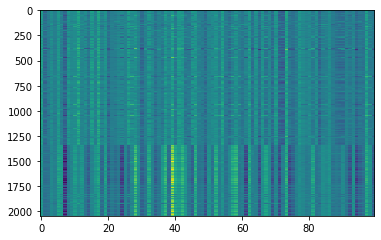

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_features, interpolation='nearest')
ax.set_aspect(0.03)

In [34]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns=['ClusterLabel'])
print(f"Number of Clusters: {max(ap.labels_)}")


Number of Clusters: 40


#### T-SNE of tunes based on Embeddings

In [36]:
assert(len(titles) == len(ft_doc_features))

In [35]:
tsne = TSNE(n_components=2, 
            random_state=0,
            perplexity = 70,
            learning_rate=100.0,
            #n_iter_without_progress=200,
            n_iter=5000
            )
#np.set_printoptions(suppress=True)
T = tsne.fit_transform(ft_doc_features)

In [37]:
projected = pd.DataFrame(T)
projected['tune'] = titles['title']
#projected['cluster'] = df_cluster['ClusterLabel'].astype(str)
projected['mode'] = meta['tune_mode']

fig = px.scatter(
    projected, 
    x=0, y=1,
    color='mode',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

### Cluster the T-SNE Result

In [38]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
clusterer.fit(T)

clusterer.labels_

array([2, 2, 2, ..., 0, 0, 0])

In [39]:
clust_proj = pd.DataFrame(T)
clust_proj['tune'] = titles['title']
clust_proj['cluster'] = clusterer.labels_.astype(str)
clust_proj['mode'] = titles['tune_mode']

fig = px.scatter(
    clust_proj, 
    x=0, y=1,
    color='cluster',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

In [40]:
clust_proj

,0,1,tune,cluster,mode
0,3.656359,-20.020555,26-2,2,major
1,27.219627,-15.214947,500 Miles High,2,minor
2,10.918786,-24.300886,502 Blues,2,minor
3,-11.570930,14.099183,52nd Street Theme,0,major
4,-8.550107,-16.196150,9.20 Special,2,major
...,...,...,...,...,...
2041,-27.074749,17.725365,You're Foolin' Someone,0,major
2042,7.675107,0.330769,You're Lucky To Me,2,major
2043,-15.038579,11.652582,You're Nobody Till Somebody Loves You,0,major
2044,-39.497139,25.092192,Your Feet's Too Big,0,major


#### Histograms for ngrams for each Cluster

In [41]:
def plot_cluster_histograms(df, cluster, top_n=45):
  tune_ind = df.query(f'cluster=="{cluster}"').index
  tune_ind

  # filter the tunes
  tune_chords = [ data_ngrams[i] for i in tune_ind ]

  # flatten the filtered tunes
  tune_chords = [item for tune in tune_chords for item in tune]

  counts = Counter(tune_chords)
  df_chords = pd.DataFrame(counts.items(),
                      columns=['chord_ngram', 'count']).sort_values(by='count', ascending=False)

  df_chords = pd.DataFrame.from_dict(df_chords[:top_n])
  df_chords.sort_values(by=['count'], ascending=False, inplace=True)

  fig = px.bar(df_chords, x='chord_ngram', y='count', log_y=True, title=f"Cluster {cluster}")
  fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
  fig.show()

In [42]:
plot_cluster_histograms(clust_proj, cluster=0)

In [43]:
plot_cluster_histograms(clust_proj, cluster=1)

In [44]:
plot_cluster_histograms(clust_proj, cluster=2)

### Similarity Tree

In [46]:
import networkx as nx
from collections import deque

def sim_tree(model, word, top_n, max_dist):

    graph = nx.Graph()
    graph.add_node(word, dist=0)

    to_visit = deque([word])
    while len(to_visit) > 0:
        source = to_visit.popleft() # visit next node
        dist = graph.nodes[source]['dist']+1

        if dist <= max_dist: # discover new nodes
            for target, sim in model.most_similar(source, topn=top_n):
                if target not in graph:
                    to_visit.append(target)
                    graph.add_node(target, dist=dist)
                    graph.add_edge(source, target, sim=sim, dist=dist)
    return graph

In [78]:
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

def plot_tree(graph, node_size=1000, font_size=8):

    pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])

    colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors,
                           cmap='Set1', alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=font_size)

    for (n1, n2, sim) in graph.edges(data='sim'):
         nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.show()


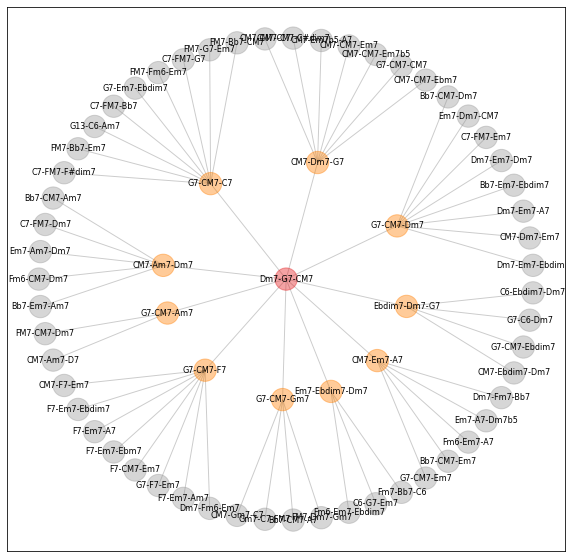

In [79]:
graph = sim_tree(model.wv, 'Dm7-G7-CM7', top_n=10, max_dist=2)
plot_tree(graph, node_size=500, font_size=8)

## Cosine Similarity between Tunes

In [83]:
ft_doc_features[0]

array([ 0.15788962, -0.21116321,  0.00448754,  0.06556095, -0.03299452,
        0.09453364, -0.06465142, -0.11791662,  0.19735894,  0.05943873,
        0.06522391,  0.29135387,  0.00991223,  0.09461593, -0.04327016,
        0.21808949, -0.05816885,  0.26627543,  0.07304374,  0.15843075,
       -0.12079779, -0.05797126,  0.01386531,  0.02892536,  0.10873079,
       -0.05092532,  0.24528297,  0.11885973,  0.02794677, -0.07143855,
       -0.14065503,  0.02875393,  0.09542966,  0.05224742, -0.12956798,
       -0.06371681, -0.12366884,  0.05904841,  0.10780623,  0.05996438,
       -0.12488688,  0.13879832,  0.08654653, -0.15916157, -0.08969639,
        0.21363467,  0.09461047,  0.03071549, -0.00986609, -0.15455969,
       -0.01374529,  0.08324788,  0.07969336, -0.01357668,  0.18724791,
       -0.10170875, -0.15499312, -0.08733513,  0.04186187,  0.03057758,
       -0.12092548,  0.12164617,  0.14479983, -0.11317284,  0.17712845,
       -0.10429336,  0.11495733, -0.19640875,  0.00559257, -0.15

In [86]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([ft_doc_features[0]], [ft_doc_features[1]])

array([[0.92979683]])

In [95]:
df_cos = pd.DataFrame(cosine_similarity(ft_doc_features),
                      columns=titles['title'],
                      index=titles['title'])
df_cos

title,26-2,500 Miles High,502 Blues,52nd Street Theme,9.20 Special,A Ballad,A Beautiful Friendship,A Blossom Fell,A Certain Smile,A Child Is Born,A Felicidade,A Fine Romance,A Flower Is A Lovesome Thing,A Foggy Day,A Ghost Of A Chance,A Kiss To Build A Dream On,A Little Tear,A Lovely Way To Spend An Evening,A Night In Tunisia,A Nightingale Sang In Berkeley Square,A Pretty Girl Is Like A Melody,A Sleepin' Bee,A Smooth One,A Sound For Sore Ears,A Sunday Kind Of Love,A Taste Of Honey,A Time For Love,A Tisket A Tasket,A Weaver Of Dreams,A Wonderful Day Like Today,Ablution,Ac-Cent-Tchu-Ate The Positive,Across The Alley From The Alamo,Adam's Apple,Affirmation,"African Queen, The",Afro Blue,Afro Centric,After You've Gone,After You,...,When Your Hair Has Turned To Silver,Whenever You're Lonesome,Where He Leads Me,Where The Saviour Leads Me,While We Danced At The Mardi Gras,Whispering,"White Cliffs Of Dover, The","White Sport Coat And A Pink Carnation, A",Who's Sorry Now,Why Don't You Go Down To New Orleans,Wild Man Blues,Willie The Weeper,Winin' Boy Blues,Wish Me Luck As You Wave Me Goodbye,"Without You For An Inspiration, Dear",Wolverine Blues,Wooden Heart,Working Man Blues,Wrap Your Troubles In Dreams,Yama Yama Man,Yearning,Yellow Dog Blues,"Yes Sir, That's My Baby",Yes! We Have No Bananas,You Always Hurt The One You Love,You Are My Sunshine,You Belong To Me,You Broke Your Promise,You Can Depend On Me,You Meet The Nicest People In Your Dreams,You Must Have Been A Beautiful Baby,"You Tell Me Your Dreams, I'll Tell You Mine",You Were Only Fooling,You're A Real Sweetheart,You're Driving Me Crazy,You're Foolin' Someone,You're Lucky To Me,You're Nobody Till Somebody Loves You,Your Feet's Too Big,Zing Went The Strings Of My Heart
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26-2,1.000000,0.929797,0.903847,0.508942,0.649611,0.971142,0.932596,0.851930,0.924740,0.735560,0.942282,0.933020,0.763385,0.948225,0.959310,0.949481,0.887595,0.955248,0.731317,0.964905,0.894258,0.885894,0.619151,0.424485,0.958299,0.814957,0.890211,0.939044,0.936947,0.934227,0.965084,0.928842,0.898572,0.413880,0.823563,0.503315,0.367927,0.898909,0.926608,0.950746,...,0.299878,0.258040,0.262551,0.279133,0.307300,0.220897,0.186833,0.244209,0.362876,0.269924,0.212208,0.269743,0.251361,0.301968,0.322246,0.241982,0.288936,0.284614,0.242426,0.296065,0.256031,0.229338,0.284677,0.259660,0.184990,0.279199,0.144851,0.236103,0.944356,0.298805,0.280507,0.254660,0.231698,0.240519,0.202907,0.258901,0.690497,0.317613,0.267436,0.170256
500 Miles High,0.929797,1.000000,0.956255,0.670069,0.734330,0.963880,0.970433,0.923196,0.975711,0.887746,0.993005,0.962911,0.865658,0.970285,0.976932,0.956500,0.959107,0.980975,0.849308,0.981792,0.960963,0.958046,0.607927,0.616500,0.971730,0.924198,0.972318,0.970080,0.992559,0.965278,0.981780,0.955786,0.959870,0.489479,0.901406,0.579661,0.451944,0.921355,0.972294,0.981015,...,0.496307,0.460956,0.459429,0.476583,0.500653,0.420150,0.387800,0.445154,0.555190,0.468284,0.433630,0.492433,0.455630,0.502332,0.511419,0.440961,0.486335,0.480398,0.453223,0.491952,0.454485,0.426602,0.481840,0.456492,0.382961,0.474799,0.348049,0.443017,0.962975,0.494763,0.481136,0.458208,0.437164,0.438822,0.407331,0.456110,0.830926,0.511673,0.463239,0.381837
502 Blues,0.903847,0.956255,1.000000,0.533169,0.649043,0.912118,0.889171,0.805384,0.905486,0.853111,0.966441,0.879258,0.751094,0.892093,0.913618,0.919143,0.858751,0.920388,0.826106,0.935256,0.872474,0.867371,0.584163,0.502388,0.900090,0.880872,0.978947,0.888758,0.957391,0.877646,0.932772,0.869216,0.882891,0.435712,0.896855,0.598038,0.532390,0.897595,0.891203,0.925101,...,0.361184,0.321747,0.325673,0.345695,0.366146,0.279588,0.249086,0.311068,0.413312,0.336878,0.314294,0.395245,0.320133,0.373180,0.369758,0.306298,0.354979,0.345486,0.318505,0.358220,0.322124,0.295296,0.348769,0.319601,0.247542,0.342819,0.212899,0.312337,0.881823,0.360351,0.345439,0.320941,0.303866,0.306863,0.270526,0.317294

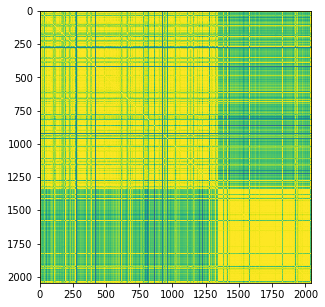

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_cos, interpolation='nearest')
ax.set_aspect(1)

In [102]:
def get_similar_tunes(df, threshold = 0.9):
  # display tunes that have a cos_sim value bigger than the threshold

  # create a series of tunes containing a list of similar tunes for each tune
  cols = df.columns
  bt = df.apply(lambda x: x > threshold)
  result = bt.apply(lambda x: list(cols[x.values]), axis=1)

  # print the result
  tuneA = []
  tuneB = []
  cos_val = []

  for idx, val in tqdm(result.iteritems()):
    # if the tune is similar to other tunes
    if len(val) <= 1:
      continue
    #print(f'{idx}')
    for tune in val:
      if tune != idx:
        #print(f'\t{df.loc[idx][tune]:.3f} - {tune}')
        tuneA.append(idx)
        tuneB.append(tune)
        cos_val.append(df.loc[idx][tune])

  df_result = pd.DataFrame(list(zip(tuneA,
                                    tuneB,
                                    cos_val)),
                           columns=['tuneA', 'tuneB', 'cos_val']
                           )
  df_result.sort_values(['tuneA', 'cos_val'], ascending=[True, False], inplace=True)
  return df_result

In [117]:
# threshold for the cosinus similarity value to display
COS_THRES = 0.8

In [125]:
nn = 100 # limit the number of tunes to speed up

df_result_chords = get_similar_tunes(df_cos.iloc[0:nn,0:nn], 
                                     threshold=COS_THRES)

100it [00:00, 147.60it/s]


In [128]:
df_result_chords['tuneA'].unique()

array(['26-2', '500 Miles High', '502 Blues', '52nd Street Theme',
       '9.20 Special', 'A Ballad', 'A Beautiful Friendship',
       'A Blossom Fell', 'A Certain Smile', 'A Child Is Born',
       'A Felicidade', 'A Fine Romance', 'A Flower Is A Lovesome Thing',
       'A Foggy Day', 'A Ghost Of A Chance', 'A Kiss To Build A Dream On',
       'A Little Tear', 'A Lovely Way To Spend An Evening',
       'A Night In Tunisia', 'A Nightingale Sang In Berkeley Square',
       'A Pretty Girl Is Like A Melody', "A Sleepin' Bee",
       'A Sound For Sore Ears', 'A Sunday Kind Of Love',
       'A Taste Of Honey', 'A Time For Love', 'A Tisket A Tasket',
       'A Weaver Of Dreams', 'A Wonderful Day Like Today', 'Ablution',
       'Ac-Cent-Tchu-Ate The Positive', 'Across The Alley From The Alamo',
       "Adam's Apple", 'Affirmation', 'Afro Centric', 'After You',
       "After You've Gone", 'Afternoon In Paris', 'Again',
       'Agua De Beber', 'Ahmid-6', "Ain't Misbehavin'", "Ain't She Sweet",
 

In [129]:
df_result_chords.query('tuneA == "Autumn Leaves"').reset_index()

,index,tuneA,tuneB,cos_val
0,6671,Autumn Leaves,Alone Together,0.992057
1,6635,Autumn Leaves,A Time For Love,0.979436
2,6615,Autumn Leaves,500 Miles High,0.974389
3,6616,Autumn Leaves,502 Blues,0.972895
4,6622,Autumn Leaves,A Felicidade,0.968858
...,...,...,...,...
77,6694,Autumn Leaves,Autumn Nocturne,0.862328
78,6686,Autumn Leaves,Armando's Rhumba,0.856239
79,6684,Autumn Leaves,April,0.850638
80,6619,Autumn Leaves,A Blossom Fell,0.844780
